## Import requirements library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import cv2
import os

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Conv2D, Dropout, BatchNormalization
import tensorflow_hub as hub
from keras_preprocessing.image import ImageDataGenerator

## Dataset path 

In [2]:
data_path = 'cassava-leaf-disease-classification'

train_csv_data_path = os.path.join(data_path, 'train.csv')
label_json_data_path = os.path.join(data_path, 'label_num_to_disease_map.json')
images_dir_data_path = os.path.join(data_path, 'train_images')

In [3]:
train_df = pd.read_csv(train_csv_data_path)
train_df["label"] = train_df["label"].astype("string") # for Keras flow_from_dataframe

In [4]:
coun_total_data = len(train_df)
count_train_data = int(0.8 * coun_total_data)
count_valid_data = coun_total_data - count_train_data

In [5]:
label_class = pd.read_json(label_json_data_path, orient='index')
label_class

,0
0,Cassava Bacterial Blight (CBB)
1,Cassava Brown Streak Disease (CBSD)
2,Cassava Green Mottle (CGM)
3,Cassava Mosaic Disease (CMD)
4,Healthy


## Prepare data for training 

### input detail

In [67]:
Batch_Size = 16
Image_Width = 512
Image_Height = 512
Image_Channel = 3
num_classes = 5

### label bar plot

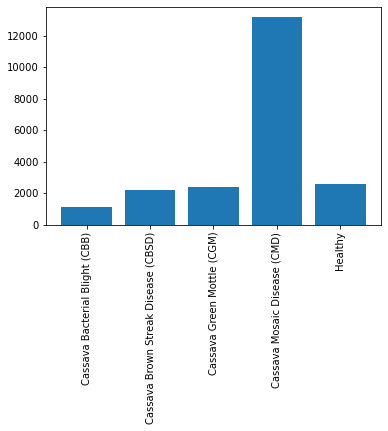

In [7]:
train_data = train_df.to_numpy()

class_number_data = {label_class.to_dict()[0][counter] : sum(train_data[:,1] == str(counter)) for counter in range(5)}

plt.bar(range(len(class_number_data)), list(class_number_data.values()), align='center')
plt.xticks(range(len(class_number_data)), list(class_number_data.keys()), rotation=90)
plt.show()

### Show some sample images

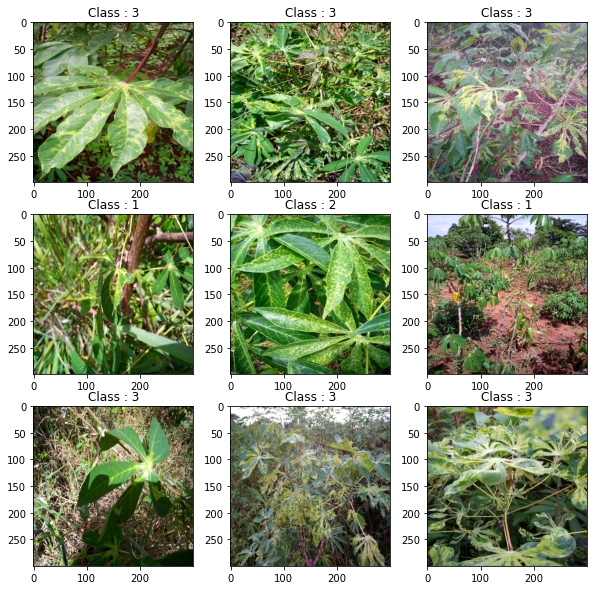

In [8]:
rnd_index = np.random.randint(0, high=len(train_data), size=9)
plt.figure(figsize=(10,10))
for counter, index in enumerate(rnd_index):
    image_name = os.path.join(images_dir_data_path, train_data[index, 0])
    img = cv2.imread(image_name)[...,::-1]
    resized_img = cv2.resize(img, (Image_Width, Image_Height)).reshape(Image_Width, Image_Height, Image_Channel)/255
    plt.subplot(3,3,counter+1)
    plt.title('Class : {}'.format(train_data[index, 1]))
    plt.imshow(resized_img)

### prepare dataset

In [61]:
tfrecord_list = os.listdir(os.path.join(data_path, 'train_tfrecords'))
tfrecord_list = [os.path.join(os.path.join(data_path, 'train_tfrecords'), name) for name in tfrecord_list]

In [62]:
AUTO = tf.data.experimental.AUTOTUNE

def decode_image(data):
    image = tf.image.decode_jpeg(data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [Image_Width, Image_Height, Image_Channel]) # explicit size needed for TPU
    return image

In [63]:
def read_tfrecord(example):
    # Create a dictionary describing the features.
    train_feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'image_name': tf.io.FixedLenFeature([], tf.string),
        'target': tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, train_feature_description)
    image = decode_image(example['image'])
    image_name = example['image_name']
    target = tf.cast(example['target'], tf.int32)
    return image, target

In [64]:
def load_dataset(filenames, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    # automatically interleaves reads from multiple files
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.map(read_tfrecord)
    # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.with_options(ignore_order)
    return dataset

In [65]:
# At first, make a vanilla training dataset by just loading from TFRecord files.
# The order should be maintained.
training_ds = load_dataset(tfrecord_list, ordered=True)

print(training_ds)

<_OptionsDataset shapes: ((512, 512, 3), ()), types: (tf.float32, tf.int32)>


In [85]:
import time

start = time.time()
counter=0
Shapes = []
for image_raw, target in training_ds:
    counter += 1
    image_raw_int = image_raw.numpy()
    Shapes.append(list(image_raw_int.shape))
    if counter % 500 == 0:
        print(counter)
print('Full Time : {}'.format(time.time() - start))


500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
Full Time : 124.29796314239502


In [68]:
# Extract target values from the vanilla training dataset.
# Indices are generated along with the target values, which are used to filter dataset.
y_targets = np.array([ target.numpy() for _, target in iter(training_ds) ])
X_indices = np.arange(len(y_targets))

#print_target_counts(y_targets, "Total")

### augmentation and seperate train and validation

In [78]:
from sklearn.model_selection import train_test_split

# Split the generated indices and target values by train_test_split().
# The ratio of target values should be kept in the splitted datasets.
X_train_indices, X_val_indices, y_train_targets, y_val_targets = train_test_split(
    X_indices, y_targets, test_size=0.2, stratify=y_targets, random_state=53)

In [79]:
def get_selected_dataset(ds, X_indices_np):
    # Make a tensor of type tf.int64 to match the one by Dataset.enumerate(). 
    X_indices_ts = tf.constant(X_indices_np, dtype=tf.int64)
    
    def is_index_in(index, rest):
        # Returns True if the specified index value is included in X_indices_ts.
        #
        # '==' compares the specified index value with each values in X_indices_ts.
        # The result is a boolean tensor, looks like [ False, True, ..., False ].
        # reduce_any() returns Ture if True is included in the specified tensor.
        return tf.math.reduce_any(index == X_indices_ts)
    
    def drop_index(index, rest):
        return rest

    # Dataset.enumerate() is similter to Python's enumerate().
    # The method adds indices to each elements. Then, the elements are filtered
    # by using the specified indices. Finally unnecessary indices are dropped.
    selected_ds = ds \
        .enumerate() \
        .filter(is_index_in) \
        .map(drop_index)
    return selected_ds

In [81]:
splitted_train_ds = get_selected_dataset(training_ds, X_train_indices)
splitted_val_ds = get_selected_dataset(training_ds, X_val_indices)

print(splitted_train_ds)
print(splitted_val_ds)

<MapDataset shapes: ((512, 512, 3), ()), types: (tf.float32, tf.int32)>
<MapDataset shapes: ((512, 512, 3), ()), types: (tf.float32, tf.int32)>


In [82]:
def data_augment(image, target):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image, target

def get_training_dataset():
    dataset = splitted_train_ds
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset():
    dataset = splitted_val_ds
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

In [84]:
NUM_TRAINING_IMAGES = len(y_train_targets)
NUM_VALIDATION_IMAGES = len(y_val_targets)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // Batch_Size
print('Dataset: {} training images, {} validation images'.format(
    NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES))

Dataset: 17117 training images, 4280 validation images


## Load EfficientNet(B0, B1, B2, ...., B7) models from tensorflow_hub

In [26]:
model = tf.keras.Sequential([
    hub.KerasLayer("models/pretrained/efficientnet_b0_feature-vector_1/", # you need to set to "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
                   trainable=False),  # Can be True, see below.
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   multiple                  4049564   
_________________________________________________________________
dense_2 (Dense)              multiple                  6405      
Total params: 4,055,969
Trainable params: 6,405
Non-trainable params: 4,049,564
_________________________________________________________________


## Visualising high-dimensional datasets using PCA and t-SNE in Python